# Traffic Sign Classification using NN

- Author: Yiran Jing
- Date: Nov 2020
- Group: CP32-17b1 (COMP3988 group 1)


In [3]:
import matplotlib.pyplot as plt
from os import listdir, rename, listdir
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns

import cv2
import numpy as np
import platform
import tempfile
import time
import sys
import shutil
import glob

import config as cfg
from TFmodel_helper_function import *

### Load dataset and visualization

In [4]:
folder = "data"
labels = [ "stop", "right", "left", "park", "speed_50_white"]


### Original dataset size

# OpenCV pre-processing 

Note that if the images fail to be detected using OpenCV, then they willnot be collected by roi output folder. And thus willnot be used to train model.

We are trying to guarantee the high detection rate using openCV for each class

In [5]:
abs_path = "/Users/yiranjing/Desktop/COMP3988/Sign-Detection/Yiran/data/"

train_path = abs_path + "train/" # the path of original training images
test_path = abs_path + "test/" # the path of original test images
roi_train_path = abs_path + "trainCNN_roi/" # the path of the training rois after openCV processing
roi_test_path = abs_path + "testCNN_roi/" # the path of the test rois after openCV processing
fail_openCV = abs_path + "fail_openCV/" # the path used to collect failed image

### define the target folder we want to use to collect data

In [6]:
class_folders = ["stop/stop_simulator/", "stop/stop_realWorld/", 
                 "right/right_blue/", "right/right_realWorldImage/",
                 "left/left_blue/", "left/left_real_worldImage/",
                "park/park_green/", "park/park_yellow/","park/park_realWorld/", #"park/park_blue/", #"park/park_white/",
                 "speed_50_white/speed_50_white_simulator/", "speed_50_white/speed_50_realworldImage/",
                 #"other/other_simulator/"
                ]

## Data processed by openCV for CNN model training

# CNN model

In [7]:
# Predefined Hyper-parameter 
learning_rate = 0.001
batch_size = 64
img_height = 100
img_width = 100
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Model evaluation

Reason to add confusion matrix: We select model based on accuracy, but accuracy is just a summary of all classes performance, so to see individual class performance, we should draw confusion matrix. Also, it is good to consider Precision Recall, ROC for each classes.

Based on the test data

## load Shenzhen data

In [8]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE
print("Shenzhen Test data:")
test_data_dir = pathlib.Path(abs_path + "/shenzhen_roi_filter")
image_count = len(list(test_data_dir.glob('*/*'))) # there are some png, also some jpg
print("The total number of test images are {}. \n".format(image_count))
labels = [ "stop", "right", "left", "speed_50_white", "park"]

for class_name in labels:
    path = abs_path + "shenzhen_roi_filter/" + class_name 
    #print(path)
    image_count = len(list(pathlib.Path(path).glob('*')))
    print("{}: {} images.".format(class_name, image_count))
    

 
# process data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir, 
  image_size=(img_height, img_width),
  seed=123, 
  batch_size=batch_size)
labels = test_ds.class_names


test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Shenzhen Test data:
The total number of test images are 735. 

stop: 577 images.
right: 17 images.
left: 135 images.
speed_50_white: 0 images.
park: 6 images.
Found 732 files belonging to 5 classes.


### True detection rate using openCV
1. Stop: 584 / 649 = **0.9** (good enough)
2. right-blue-turn: 17/169 = 0.1
3. left-blue-turn (new): 135/174 = 0.776
4. green-park: 6/83 = 0.072

In [9]:
## load model 
from tensorflow.keras.models import load_model
cnn = load_model('../../model/sign.h5')

Confusion Matrix, x label is Predicted_Label, y is True_Label


/Users/yiranjing/Desktop/comp3988_t17b_group1/sign_detection_code/Yiran/TFmodel_helper_function.py:323: RuntimeWarning: invalid value encountered in true_divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


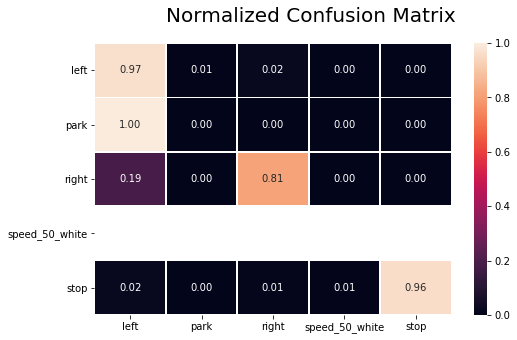

Classification Report bazed on test data
                precision    recall  f1-score   support

          left       0.86      0.97      0.91       134
          park       0.00      0.00      0.00         6
         right       0.62      0.81      0.70        16
speed_50_white       0.00      0.00      0.00         0
          stop       1.00      0.96      0.98       576

      accuracy                           0.95       732
     macro avg       0.49      0.55      0.52       732
  weighted avg       0.96      0.95      0.95       732



/Users/yiranjing/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [10]:
draw_confusion_matrix(cnn, test_ds, class_names = labels)

- Model get good prediction result on the left sign (true positive = 0.98), and stop (true positive = 0.99)
- relative good result on right sign (true positive = 0.81, false positive mainly in left)
- bad result on park (true positive = 0.33, false positive mainly in left)